In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/activity")

In [3]:
import subsampling as ss
import activity_assembly as actvt
from core import SITE_NAMES, FREQ_GROUPS, SEATTLE_LATITUDE, SEATTLE_LONGITUDE

from cli import get_file_paths
import plot
import pipeline

In [4]:
POINT_CMAP = {0:'w',1:'r',2:'b',3:'g',4:'orange',5:'c',6:'pink',7:'k'}
POINT_CMAP

{0: 'w', 1: 'r', 2: 'b', 3: 'g', 4: 'orange', 5: 'c', 6: 'pink', 7: 'k'}

In [5]:
def get_time_on_for_dc_per_bin(clength_in_mins, time_on_in_mins, actvt_metric):
    slots = pd.date_range(actvt_metric.index[0], actvt_metric.index[-1], freq=f'1T', inclusive='left')
    dc_scheme = pd.DataFrame(index=slots)
    num_reps =np.floor(len(slots)/clength_in_mins).astype(int)
    time_ons = ([1]*time_on_in_mins + [0]*(clength_in_mins-time_on_in_mins)) * num_reps
    remaining_mins = (len(slots) - len(time_ons))
    if remaining_mins > 0:
        if remaining_mins > time_on_in_mins:
            dc_scheme['time_on_in_mins'] = time_ons + ([1]*time_on_in_mins + [0]*(remaining_mins-time_on_in_mins))
        else:
            dc_scheme['time_on_in_mins'] = time_ons + ([1]*remaining_mins)
    else:
        dc_scheme['time_on_in_mins'] = time_ons

    dc_scheme_on = dc_scheme.resample('30T').sum()
    dc_scheme_on['time_on_in_secs'] = dc_scheme_on['time_on_in_mins'] * 60
    dc_scheme_on['time_on_in_hours'] = dc_scheme_on['time_on_in_mins'] / 60
    return dc_scheme_on

In [6]:
def get_desired_metrics_from_activity_section(actvt_metric, data_params):
    c_lengths = []

    time_ons_per_dc = pd.DataFrame()
    high_actvt_metric = pd.DataFrame()
    for i, col_name in enumerate(data_params["dc_tags"]):
        dc_tag = re.search(r"\d+of\d+", col_name)[0]
        on = int(re.findall(r"\d+", dc_tag)[0])
        total = int(re.findall(r"\d+", dc_tag)[-1])
        dc_actvt = actvt_metric[f'{data_params["metric_tag"]} ({col_name})'].copy()
        if i > 0:
            c_lengths.append(total)

        dc_scheme_on = get_time_on_for_dc_per_bin(total, on, dc_actvt)
        time_ons_per_dc[f'time_on_in_mins ({dc_tag})'] = dc_scheme_on['time_on_in_mins']

        standard_metric = data_params['metric_tag']
        if data_params["metric_tag"]=='num_dets':
            standard_metric = 'call_rate_per_hour'
            rep_dc_actvt = dc_actvt / dc_scheme_on['time_on_in_hours']
        elif data_params["metric_tag"]=='bout_time':
            standard_metric = 'BTP'
            rep_dc_actvt = 100*(dc_actvt / dc_scheme_on['time_on_in_secs'])
        else:
            standard_metric = 'AI_per_hour'
            rep_dc_actvt = dc_actvt / dc_scheme_on['time_on_in_hours']

        high_actvt_metric[f'{standard_metric} ({col_name})'] = rep_dc_actvt

    high_actvt_desired_metrics = high_actvt_metric.copy()
    exp_dc_metrics = high_actvt_desired_metrics.iloc[:,1:]
    control_dc_metrics = high_actvt_desired_metrics.iloc[:,0]

    metrics = dict()
    metrics['time_ons_per_dc'] = time_ons_per_dc
    metrics['exp_metric'] = exp_dc_metrics
    metrics['control_metric'] = control_dc_metrics
    metrics['cycle_lengths'] = c_lengths

    return metrics

In [7]:
def plot_dc_control_comp_over_cycle(metrics, data_params):
    plot_key = data_params['type_tag']
    if data_params['type_tag']=='':
        plot_key = 'All'
    plt.figure(figsize=(4.8*len(data_params["percent_ons"]), 4*len(data_params["cycle_lengths"])))
    plt.rcParams.update({'font.size':12})
    plt.suptitle(f'{data_params["metric_tag"]} {data_params["site_tag"]} {plot_key} {data_params["start"]} to {data_params["end"]}', 
                        fontsize=24, y=1.01, weight='bold')
    for i in range(metrics['exp_metric'].shape[1]):
        plt.subplot(len(data_params["cycle_lengths"]),
                    len(data_params["percent_ons"]), i+1)
        
        single_col_dc_metr1 = pd.DataFrame(metrics['exp_metric'].iloc[:,i])
        single_col_c_metr = pd.DataFrame(metrics['control_metric'])
        plot_indiv_dc_control_comp_over_cycle(single_col_dc_metr1, single_col_c_metr, data_params)

    plt.tight_layout()
    plt.show()

def plot_indiv_dc_control_comp_over_cycle(single_col_dc_metr1, single_col_c_metr, data_params):
    dc_tag_split = re.findall(r"\d+", single_col_dc_metr1.columns[0])
    total = int(dc_tag_split[-1])
    single_col_dc_metr1.index = pd.DatetimeIndex(single_col_dc_metr1.index)
    dc_metr1 = pd.pivot_table(single_col_dc_metr1, index=(single_col_dc_metr1.index.time), 
                        columns=single_col_dc_metr1.index.date, 
                        values=single_col_dc_metr1.columns[0])
    dctag1 = re.search(r"\d+of\d+", single_col_dc_metr1.columns[0])[0]
    metrictag1 = (single_col_dc_metr1.columns[0]).split()[0]
    single_col_c_metr.index = pd.DatetimeIndex(single_col_c_metr.index)
    paired_col_c_metr = single_col_c_metr[(~single_col_dc_metr1.isna()).values]
    c_metr = pd.pivot_table(paired_col_c_metr, index=(paired_col_c_metr.index.time), 
                    columns=paired_col_c_metr.index.date, 
                    values=paired_col_c_metr.columns[0])
    plt.title(f'{dctag1} and continuous scheme')
    plt.plot([0, np.amax(c_metr)], [0, np.amax(c_metr)], linestyle='dashed', color='k')
    colors = np.tile(np.arange(0, c_metr.shape[0]),(c_metr.shape[1],1)).T
    labels = pd.to_datetime(c_metr.index, format='%H:%M:%S').strftime('%H:%M')
    sc = plt.scatter(c_metr, dc_metr1, c=colors, cmap='YlOrRd', edgecolors='k', s=50, alpha=0.8)
    cbar = plt.colorbar(sc, ticks=[0, (colors.shape[0]-1)//2, colors.shape[0]-1])
    cbar.ax.set_yticklabels([labels[0], labels[len(labels)//2], labels[-1]])
    plt.xlabel(f'Continuous Measured {metrictag1}')
    plt.xscale('log')
    plt.yscale('log')
    if (data_params['metric_tag'] == 'bout_time'):
        plt.xlim(1e-2, 1e2)
        plt.ylim(1e-2, 1e2)
    else:
        plt.xlim(1e-1, np.amax(c_metr))
        plt.ylim(1e-1, np.amax(c_metr))
    plt.ylabel(f'DC Measured {metrictag1}')
    plt.grid(which='both')

In [8]:
avail = np.arange(0, 720, 6) + 6
reset_24 = avail[np.where((24*60 % avail) == 0)[0]]
reset_24

array([  6,  12,  18,  24,  30,  36,  48,  60,  72,  90,  96, 120, 144,
       180, 240, 288, 360, 480, 720])

In [9]:
cycle_lengths = [6, 18, 30, 60, 144, 180]
percent_ons = [1/6, 1/3, 1/2, 2/3]
data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
data_params['index_time_block_in_secs'] = '5'
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])

In [10]:
site_key = 'Carp'
type_keys = ['LF', 'HF']
data_params['bin_size'] = '30'
data_params["dc_tags"] = dc_tags
data_params["site_tag"] = site_key
data_params['cur_dc_tag'] = '30of30'
data_params["site_name"] = SITE_NAMES[site_key]

# for type_key in type_keys:
type_key = 'LF'
print(site_key, type_key)
data_params["type_tag"] = type_key
file_paths = get_file_paths(data_params)
file_paths

Carp LF


{'raw_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/raw/Carp',
 'SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp',
 'SITE_classes_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp',
 'SITE_classes_file': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp/2022_Carp_call_classes.csv',
 'bd2_TYPE_SITE_YEAR': 'bd2__LFCarp_2022',
 'duty_cycled_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp/duty_cycled',
 'dc_dets_TYPE_SITE_summary': 'dc_dets_LFCarp_summary',
 'dc_bouts_TYPE_SITE_summary': 'dc_bouts_LFCarp_summary',
 'dc_inds_TYPE_SITE_summary': 'dc_inds_LFCarp_summary',
 'figures_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../figures/Carp',
 'activity_det_comparisons_figname': 'activity_det_comparisons_per_dc_LFCarp',
 'dc_det_comparisons_figname': 'dc_det_comparisons_per_night_LFCarp',
 

In [120]:
def simulate_dutycycle_on_detections(location_df, cycle_length, time_on_in_secs):
    """
    Simulates a provided duty-cycling scheme on the provided location summary of concatenated bd2 outputs.
    """ 

    location_df = assign_cycle_groups_to_each_call(location_df, cycle_length)
    dc_applied_df = gather_calls_existing_in_on_windows(location_df, time_on_in_secs)

    return dc_applied_df

def gather_calls_existing_in_on_windows(location_df, time_on_in_secs):

    location_df.insert(0, 'end_time_wrt_ref', (location_df['call_end_time'] - location_df['cycle_ref_time']).dt.total_seconds())
    location_df.insert(0, 'start_time_wrt_ref', (location_df['call_start_time'] - location_df['cycle_ref_time']).dt.total_seconds())
    dc_applied_df = location_df.loc[(location_df['end_time_wrt_ref'] <= time_on_in_secs)&(location_df['start_time_wrt_ref'] >= 0)].copy()

    return dc_applied_df

def assign_cycle_groups_to_each_call(location_df, cycle_length):
    location_df['ref_time'] = pd.DatetimeIndex(location_df['call_start_time'])
    location_df['cycle_ref_time'] = pd.DatetimeIndex(location_df['call_start_time'])
    location_df['call_end_time'] = pd.DatetimeIndex(location_df['call_end_time'])
    location_df['call_start_time'] = pd.DatetimeIndex(location_df['call_start_time'])

    resampled_cycle_length_df = location_df.resample(f'{cycle_length}T', on='cycle_ref_time', origin='start_day')
    location_df['cycle_ref_time'] = pd.DatetimeIndex(resampled_cycle_length_df['cycle_ref_time'].transform(lambda x: x.name))

    return location_df

In [235]:
def get_number_of_detections_per_cycle(location_df, cycle_length):

    df_resampled_every_30 = location_df.resample(f"{cycle_length}T", on='cycle_ref_time')
    num_of_detections = df_resampled_every_30['cycle_ref_time'].count()

    return num_of_detections

def get_calls_per_time_on(num_of_detections, time_on):

    return num_of_detections / (time_on)

def filter_and_prepare_metric(metric, dc_tag, data_params):

    col_name = f"{data_params['metric_tag']} ({dc_tag})"
    incomplete_activity_arr = pd.DataFrame(metric.values, index=metric.index, columns=[col_name])
    activity_arr = incomplete_activity_arr.between_time(data_params['recording_start'], data_params['recording_end'], inclusive='left')

    return pd.DataFrame(list(zip(activity_arr.index, activity_arr[col_name].values)), columns=["datetime_UTC", col_name])

In [236]:
dc_tag = '2of12'
data_params['metric_tag'] = 'call_rate'
data_params['bin_size'] = '30'
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'

In [237]:
dc_schemes = data_params['dc_tags'][1:]
cont_scheme = data_params['dc_tags'][0]

In [206]:
activity_arr = pd.DataFrame()
location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)

for dc_tag in dc_schemes:
    cycle_length_in_mins = int(dc_tag.split('of')[1])
    time_on_in_mins = int(dc_tag.split('of')[0])
    time_on_in_secs = (60*time_on_in_mins)
    time_on_in_hours = (time_on_in_mins/60)
    dc_applied_df = simulate_dutycycle_on_detections(location_df.copy(), cycle_length_in_mins, time_on_in_secs)
    num_of_detections = get_number_of_detections_per_cycle(dc_applied_df, cycle_length_in_mins)
    call_rate = get_calls_per_time_on(num_of_detections, time_on_in_mins)
    call_rate_dc_column = filter_and_prepare_metric(call_rate, dc_tag, data_params)
    call_rate_dc_column = call_rate_dc_column.set_index("datetime_UTC")
    activity_arr = pd.concat([activity_arr, call_rate_dc_column], axis=1)

activity_arr

,call_rate (1of6),call_rate (2of6),call_rate (3of6),call_rate (4of6),call_rate (3of18),call_rate (6of18),call_rate (9of18),call_rate (12of18),call_rate (5of30),call_rate (10of30),...,call_rate (30of60),call_rate (40of60),call_rate (24of144),call_rate (48of144),call_rate (72of144),call_rate (96of144),call_rate (30of180),call_rate (60of180),call_rate (90of180),call_rate (120of180)
datetime_UTC,,,,,,,,,,,,,,,,,,,,,
2022-07-13 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.358333
2022-07-13 04:48:00,NaN,NaN,NaN,NaN,NaN,0.166667,4.222222,3.583333,NaN,NaN,...,NaN,NaN,3.166667,1.687500,3.819444,4.187500,NaN,NaN,NaN,NaN
2022-07-13 04:54:00,NaN,18.5,12.333333,10.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-13 05:00:00,NaN,0.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,3.3,...,1.266667,1.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-13 05:06:00,NaN,0.0,0.666667,0.5,0.666667,0.333333,0.222222,0.166667,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-17 09:18:00,NaN,NaN,0.666667,0.5,0.666667,0.333333,0.222222,0.166667,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-17 09:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,0.020833,0.013889,0.010417,NaN,NaN,NaN,NaN
2022-10-17 09:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [255]:
metric_for_scheme = pd.DataFrame(activity_arr.iloc[:,3].dropna())
metric_for_scheme

,call_rate (4of6)
datetime_UTC,
2022-07-13 04:54:00,10.5
2022-07-13 05:00:00,0.0
2022-07-13 05:06:00,0.5
2022-07-13 05:12:00,0.0
2022-07-13 05:18:00,0.0
...,...
2022-10-17 08:54:00,0.0
2022-10-17 09:00:00,0.0
2022-10-17 09:06:00,0.0


In [256]:
dc_tag_split = re.findall(r"\d+", metric_for_scheme.columns[0])
dc_tag = re.findall(r"\d+of\d+", metric_for_scheme.columns[0])[0]
cycle_length = int(dc_tag_split[-1])
time_on = int(dc_tag_split[0])
time_on, cycle_length, dc_tag

(4, 6, '4of6')

In [257]:
location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', index_col=0)
location_df = assign_cycle_groups_to_each_call(location_df, cycle_length)
num_of_detections = get_number_of_detections_per_cycle(location_df, cycle_length)
call_rate = get_calls_per_time_on(num_of_detections, cycle_length)
call_rate_cont_column = filter_and_prepare_metric(call_rate, dc_tag, data_params)
call_rate_cont_column = call_rate_cont_column.set_index("datetime_UTC")

In [258]:
call_rate_cont_column

,call_rate (4of6)
datetime_UTC,
2022-07-13 04:48:00,0.166667
2022-07-13 04:54:00,7.000000
2022-07-13 05:00:00,5.166667
2022-07-13 05:06:00,0.333333
2022-07-13 05:12:00,0.000000
...,...
2022-10-17 09:54:00,0.000000
2022-10-17 10:00:00,0.000000
2022-10-17 10:06:00,0.000000


In [259]:
metric_for_scheme_for_comparison = metric_for_scheme.reindex(call_rate_cont_column.index, fill_value=0)
metric_for_scheme_for_comparison

,call_rate (4of6)
datetime_UTC,
2022-07-13 04:48:00,0.0
2022-07-13 04:54:00,10.5
2022-07-13 05:00:00,0.0
2022-07-13 05:06:00,0.5
2022-07-13 05:12:00,0.0
...,...
2022-10-17 09:54:00,0.0
2022-10-17 10:00:00,0.0
2022-10-17 10:06:00,0.0


In [260]:
assert (metric_for_scheme_for_comparison.loc[metric_for_scheme.index].compare(metric_for_scheme).empty)

In [261]:
metric_for_scheme_for_comparison.loc[metric_for_scheme.index]

,call_rate (4of6)
datetime_UTC,
2022-07-13 04:54:00,10.5
2022-07-13 05:00:00,0.0
2022-07-13 05:06:00,0.5
2022-07-13 05:12:00,0.0
2022-07-13 05:18:00,0.0
...,...
2022-10-17 08:54:00,0.0
2022-10-17 09:00:00,0.0
2022-10-17 09:06:00,0.0


In [262]:
assert (True in (metric_for_scheme_for_comparison > 0).values)

In [263]:
data_params['start'] = dt.datetime(2022, 8, 10, 0, 0, 0)
data_params['end'] = dt.datetime(2022, 8, 16, 16, 0, 0)


plt_dcmetr = metric_for_scheme_for_comparison.loc[data_params['start']:data_params['end']].copy()
plt_cmetr = call_rate_cont_column.loc[data_params['start']:data_params['end']].copy()

In [264]:
dc_metr1 = pd.pivot_table(plt_dcmetr, index=(plt_dcmetr.index.time), 
                    columns=plt_dcmetr.index.date, 
                    values=plt_dcmetr.columns[0])
dc_metr1.iloc[32:64]

,2022-08-10,2022-08-11,2022-08-12,2022-08-13,2022-08-14,2022-08-15,2022-08-16
03:12:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
03:18:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
03:24:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
03:30:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
03:36:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
03:42:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
03:48:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
03:54:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
04:00:00,0.00,4.25,0.00,0.25,0.75,1.75,0.00
04:06:00,0.25,38.00,0.25,0.00,1.25,5.25,0.00


In [265]:
metrictag1 = (plt_dcmetr.columns[0]).split()[0]
c_metr = pd.pivot_table(plt_cmetr, index=(plt_cmetr.index.time), 
                columns=plt_cmetr.index.date, 
                values=plt_cmetr.columns[0])
c_metr.iloc[32:64]

,2022-08-10,2022-08-11,2022-08-12,2022-08-13,2022-08-14,2022-08-15,2022-08-16
03:12:00,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000
03:18:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
03:24:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
03:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
03:36:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
03:42:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
03:48:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
03:54:00,0.000000,12.833333,0.000000,0.000000,0.000000,0.000000,0.000000
04:00:00,0.000000,2.833333,0.000000,6.000000,0.500000,5.000000,0.000000
04:06:00,0.166667,56.500000,0.166667,0.000000,0.833333,9.666667,4.333333


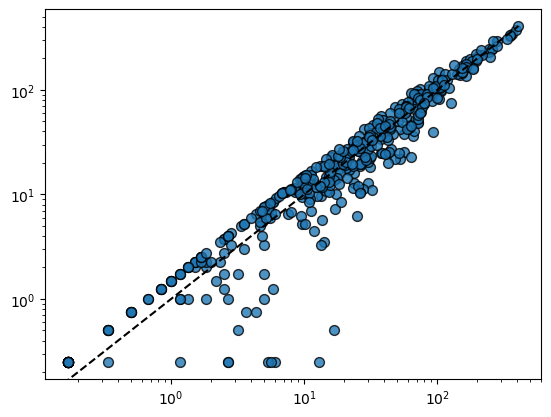

In [266]:
plt.plot([0, np.amax(c_metr)], [0, np.amax(c_metr)], linestyle='dashed', color='k')
plt.scatter(c_metr, dc_metr1, edgecolors='k', s=50, alpha=0.8)
plt.xscale('log')
plt.yscale('log')

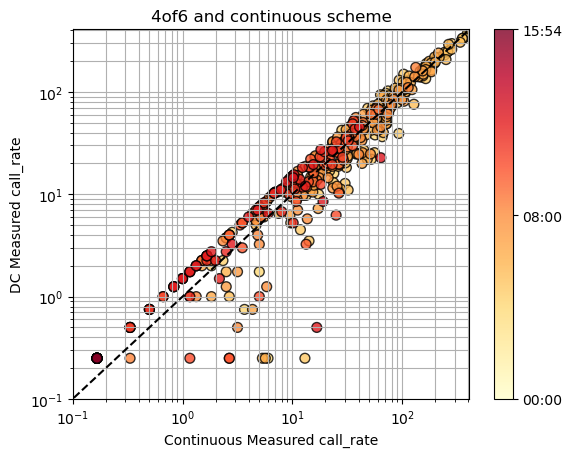

In [267]:
plt.title(f'{dc_tag} and continuous scheme')
plt.plot([0, np.amax(c_metr)], [0, np.amax(c_metr)], linestyle='dashed', color='k')
colors = np.tile(np.arange(0, c_metr.shape[0]),(c_metr.shape[1],1)).T
labels = pd.to_datetime(c_metr.index, format='%H:%M:%S').strftime('%H:%M')
sc = plt.scatter(c_metr, dc_metr1, c=colors, cmap='YlOrRd', edgecolors='k', s=50, alpha=0.8)
cbar = plt.colorbar(sc, ticks=[0, (colors.shape[0]-1)//2, colors.shape[0]-1])
cbar.ax.set_yticklabels([labels[0], labels[len(labels)//2], labels[-1]])
plt.xlabel(f'Continuous Measured {metrictag1}')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-1, np.amax(c_metr))
plt.ylim(1e-1, np.amax(c_metr))
plt.ylabel(f'DC Measured {metrictag1}')
plt.grid(which='both')

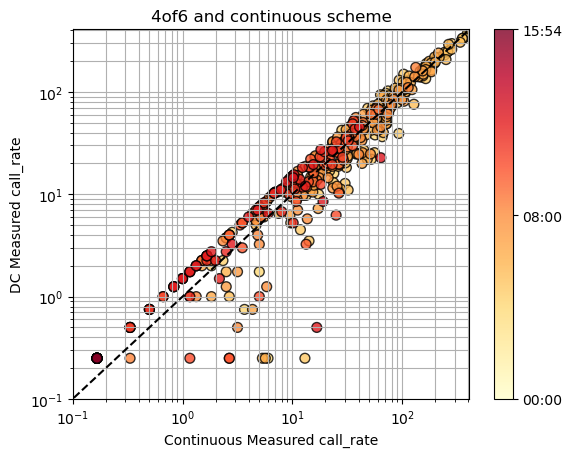

In [268]:
plot_indiv_dc_control_comp_over_cycle(plt_dcmetr, plt_cmetr, data_params)

In [294]:
over_dc_test = dc_metr1[dc_metr1 > c_metr]
under_dc_test = dc_metr1[c_metr > dc_metr1]
over_c_test = c_metr[dc_metr1 > c_metr]
under_c_test = c_metr[c_metr > dc_metr1]
over_ratios = (over_dc_test / over_c_test)
under_ratios = (under_dc_test / under_c_test)
over_ratios

,2022-08-10,2022-08-11,2022-08-12,2022-08-13,2022-08-14,2022-08-15,2022-08-16
00:00:00,NaN,NaN,1.5,NaN,NaN,NaN,NaN
00:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:24:00,NaN,NaN,NaN,NaN,1.5,NaN,NaN
...,...,...,...,...,...,...,...
15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15:42:00,1.5,NaN,NaN,1.5,NaN,NaN,NaN
15:48:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [295]:
under_ratios

,2022-08-10,2022-08-11,2022-08-12,2022-08-13,2022-08-14,2022-08-15,2022-08-16
00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15:48:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [296]:
most_ratio = stats.mode((over_ratios.values)[~over_ratios.isna()])[0]
all_most = over_ratios[over_ratios==most_ratio]
most_ratio

1.5

In [304]:
dc_metr1[dc_metr1==all_most*c_metr]

,2022-08-10,2022-08-11,2022-08-12,2022-08-13,2022-08-14,2022-08-15,2022-08-16
00:00:00,NaN,NaN,0.25,NaN,NaN,NaN,NaN
00:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:24:00,NaN,NaN,NaN,NaN,0.25,NaN,NaN
...,...,...,...,...,...,...,...
15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15:42:00,0.25,NaN,NaN,0.25,NaN,NaN,NaN
15:48:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


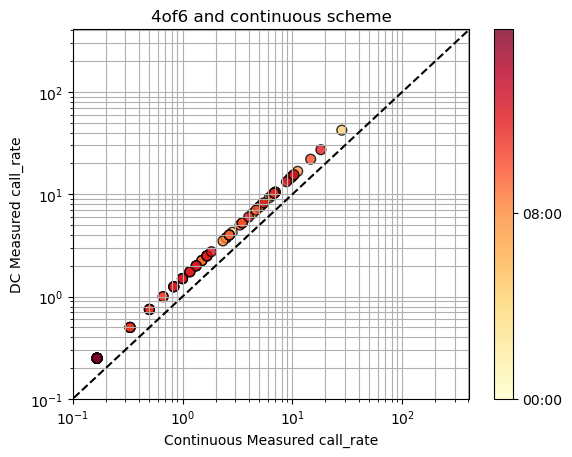

In [305]:
plt.title(f'{dc_tag} and continuous scheme')
plt.plot([0, np.amax(c_metr)], [0, np.amax(c_metr)], linestyle='dashed', color='k')
colors = np.tile(np.arange(0, c_metr.shape[0]),(c_metr.shape[1],1)).T
labels = pd.to_datetime(c_metr.index, format='%H:%M:%S').strftime('%H:%M')
sc = plt.scatter(c_metr, dc_metr1[dc_metr1==all_most*c_metr], c=colors, cmap='YlOrRd', edgecolors='k', s=50, alpha=0.8)
cbar = plt.colorbar(sc, ticks=[0, (colors.shape[0]-1)//2, colors.shape[0]-1])
cbar.ax.set_yticklabels([labels[0], labels[len(labels)//2], labels[-1]])
plt.xlabel(f'Continuous Measured {metrictag1}')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-1, np.amax(c_metr))
plt.ylim(1e-1, np.amax(c_metr))
plt.ylabel(f'DC Measured {metrictag1}')
plt.grid(which='both')